# Exploration Example

The goal of this notebook is to walk you through a sample Data Science exploration notebook that uses Azure ML features to make your life easier.  

First, you'll do some setup to bind to your Azure ML Workspace.  
Next, you'll run a classic Data Science experiment, but with a few extras to use Azure ML. In particular, this will allow you to log metrics in the Azure ML UI, so that you can track and compare your experiments much more easily.  


<b>Summary:</b>

1. [Set up](#setup)

    1. [Import Librairies](#import_libs)

    2. [Connect to Azure ML Workspace](#setup_azureml)

    3. [Set up MLFlow](#setup_mlflow)

2. [Experiment](#experiment)

    1. [Load Data](#load_data)

    2. [(Optional) Create Data Assets](#create_data_assets)

    3. [(Optional) Load Data Assets](#load_data_assets)

    4. [Prepare Data](#prepare_data)

    5. [Train Model](#train_model)

    6. [Evaluate Model](#evaluate_model)
    
    7. [Retrieve Logged Metadata](#retrieve_metadata)

## Set up <a name="setup"></a>

In order to log metadata about your experiments in Azure ML, you must use MLFlow. MLFlow is an open source tool, which Azure ML has integrated into their platform.

To log metadata with MLFlow, you need to start an MLFlow run: <code>mlflow.start_run()</code>. Also, at the end of the run, you need to do <code>mlflow.end_run()</code>.

NB: In a notebook, it happens that an MLFlow run was started and was not ended, for example if one cell execution crashes in between. If this happens, uncomment the next cell and run it. Note that this won't happen in the industrialized code if the MLFlow context is well handled (with a <code>with</code> statement). You have examples of that in the <em>mlops/components</em> folder.

In [1]:
# Uncomment and run the following line of code only if an MLFlow run was started and not was not ended.
import mlflow
mlflow.end_run()

### Import Librairies <a name="import_libs"></a>

In [2]:
# Utility libs
import os
import re
import pprint
import warnings
import datetime

warnings.filterwarnings("ignore")  # Ignore warnings (they are caused by Azure ML experimental classes)

# General ML/Data libs
import pandas as pd

# AzureML/MLFlow libs
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

import mlflow
from mlflow.tracking import MlflowClient


### Connect to Azure ML Workspace <a name="setup_azureml"></a>

In order to communicate with your Azure ML workspace (create artifacts, retrieve artifacts, etc.), you need to instanciate an Azure ML client, with a proper authentication.

In [3]:
# Retrieve details of Azure ML workspace from environment variables of your Compute Instance
subscription_id = re.search("subscriptions/(.*)/resourceGroups", os.environ["MLFLOW_TRACKING_URI"]).group(
    1
)  # Extract Azure Subcription ID from MLFlow Tracking URI
resource_group = os.environ["CI_RESOURCE_GROUP"]
workspace_name = os.environ["CI_WORKSPACE"]

# Connect to Azure ML workspace
ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace_name,
)

### Set up MLFlow <a name="setup_mlflow"></a>

Here, we do three things to set up MLFlow:
- We link MLFlow to our Azure ML workspace.
- We define an experiment name, which will be a namespace in the UI with multiple runs grouped into.
- We set up the autolog module. This module is optional, but makes life easier because it logs a lot of information about our runs/models for us that we don't need to log explicitly. This only works with certain types of models, including sklearn models. Refer to the MLFlow documentation for more information.


In [4]:
# Set tracking environment
# automatically set on compute instance
# azureml_mlflow_uri = ml_client.workspaces.get(workspace_name).mlflow_tracking_uri
# mlflow.set_tracking_uri(azureml_mlflow_uri)

In [5]:
# Set experiment name
use_case_name = "taxi"
experiment_name = f"{use_case_name}-exploration"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='', creation_time=1682382196036, experiment_id='60700d7f-3afa-4610-8013-6f746b478ea7', last_update_time=None, lifecycle_stage='active', name='taxi-exploration', tags={}>

In [6]:
# Enable autologging, which works with sklearn models (among other kinds of models)
mlflow.autolog()

## Experiment <a name="experiment"></a>

In [7]:
# Start MLFlow run for logging metadata into that run
run_name = f'exploration {datetime.datetime.now().strftime("%Y-%m-%d %H:%M")}'
run = mlflow.start_run(run_name=run_name)

### Load Data <a name="load_data"></a>

We get the data from an Azure ML Datastore. An Azure ML Datastore is an entity of the Azure ML Workspace, that points to a data source (encapsulating the connection to it). Refer to the Azure ML documentation for more information.

You can see the Datastore in the UI.

NB: In the exploration phase, the Datastore used must point to a "data-science" container, where Data Scientists can upload the data files of their choice. But later, in the industrialization phase (Python files and ML Pipelines), the Datastore used must point to a "data-store" container, where the data is provided by Data Engineers in an industrialized way.

In [8]:
datastore_name = "datascience"
path_in_datastore = "/taxi-data.csv"

# Get Azure ML Datastore path where input data files reside
data_path = f"azureml://subscriptions/{subscription_id}/resourcegroups/{resource_group}/workspaces/{workspace_name}/datastores/{datastore_name}/paths/{path_in_datastore}"
data = pd.read_csv(data_path)

mlflow.set_tag("input_data_path", data_path)

NB: It is possible to load data from an Azure ML Datastore with Pandas directly thanks to the <em>azureml-fsspec</em> library.

### (Optional) Create Data Asset <a name="create_data_asset"></a>

Azure ML Data Assets are convenient entities to share datasets among Data Scientists. They are versioned and contain metadata. You can see the list of Data Assets in the UI. For more information, see Azure ML documentation.

NB: Using Data Assets in this notebook is optional. You could simply train your model with the Pandas data. But making use of Data Assets is a good practice.

In [9]:
# A Data Asset is created from a path
train_data_asset = Data(
    path=data_path,
    type=AssetTypes.URI_FILE,
    description="Dataset for Exploration",
    name="taxi-data-exploration",
)
ml_client.data.create_or_update(train_data_asset)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'taxi-data-exploration', 'description': 'Dataset for Exploration', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/d5eebdae-19f7-4198-a12e-04fdec08b615/resourceGroups/amldemos/providers/Microsoft.MachineLearningServices/workspaces/amldemos/data/taxi-data-exploration/versions/6', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mam-worstation/code/Users/maggiemhanna/mlops-v2-training/data-science/experiment', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fea67ca2a70>, 'serialize': <msrest.serialization.Serializer object at 0x7fea380cfd90>, 'version': '6', 'latest_version': None, 'path': 'azureml://subscriptions/d5eebdae-19f7-4198-a12e-04fdec08b615/resourcegroups/amldemos/workspaces/amldemos/datastores/datascience/paths

### (Optional) Load Data Assets <a name="load_data_assets"></a>

If you've previously created Data Assets, you can also load them with Pandas. The <em>azureml-fsspec</em> library is needed, like for loading data from a Datastore.

NB: When a Data Asset is created from a local file, the data is uploaded somewhere on the default Datastore. We retrieve this path first.

In [10]:
# Load each Azure ML Data Asset as a Pandas DataFrame
data_asset = ml_client.data.get(name="taxi-data-exploration", label="latest")  # Latest version of the Data Asset
data = pd.read_csv(data_asset.path, index_col=0)
data.head()

,cost,distance,dropoff_latitude,dropoff_longitude,passengers,pickup_latitude,pickup_longitude,store_forward,vendor,pickup_weekday,...,pickup_monthday,pickup_hour,pickup_minute,pickup_second,dropoff_weekday,dropoff_month,dropoff_monthday,dropoff_hour,dropoff_minute,dropoff_second
0,4.5,0.83,40.694546,-73.976112,1,40.693836,-73.987267,0,2,6,...,3,21,2,35,6,1,3,21,5,52
1,6.0,1.27,40.812149,-73.959755,1,40.801468,-73.948456,0,2,1,...,19,21,49,17,1,1,19,21,54,37
2,9.5,1.80,40.678741,-73.980309,1,40.679798,-73.955444,0,2,1,...,5,9,46,18,1,1,5,9,57,28
3,4.0,0.50,40.754715,-73.925499,1,40.760818,-73.922935,0,1,4,...,8,17,49,12,4,1,8,17,52,20
4,6.0,0.90,40.669662,-73.911041,1,40.664940,-73.923042,0,1,4,...,29,10,28,21,4,1,29,10,34,59


# Step: Prep Data

Most of useful metrics are logged by the autolog module mentionned earlier. But you can also log anything you want, like here we log metrics about the data: size of the train and test sets, number of features.

In [11]:
import argparse

from pathlib import Path
import os
import numpy as np
import pandas as pd

import mlflow

TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance", "dropoff_latitude", "dropoff_longitude", "passengers", "pickup_latitude",
    "pickup_longitude", "pickup_weekday", "pickup_month", "pickup_monthday", "pickup_hour",
    "pickup_minute", "pickup_second", "dropoff_weekday", "dropoff_month", "dropoff_monthday",
    "dropoff_hour", "dropoff_minute", "dropoff_second"
]

CAT_NOM_COLS = [
    "store_forward", "vendor"
]

CAT_ORD_COLS = [
]

raw_data = data_asset.path
train_data = "/tmp/prep/train"
val_data = "/tmp/prep/val"
test_data = "/tmp/prep/test"

os.makedirs(train_data, exist_ok = True)
os.makedirs(val_data, exist_ok = True)
os.makedirs(test_data, exist_ok = True)

'''Read, split, and save datasets'''

# ------------ Reading Data ------------ #
# -------------------------------------- #

data = pd.read_csv(raw_data)
data = data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS + [TARGET_COL]]

# ------------- Split Data ------------- #
# -------------------------------------- #

# Split data into train, val and test datasets

random_data = np.random.rand(len(data))

msk_train = random_data < 0.7
msk_val = (random_data >= 0.7) & (random_data < 0.85)
msk_test = random_data >= 0.85

train = data[msk_train]
val = data[msk_val]
test = data[msk_test]

mlflow.log_metric('train size', train.shape[0])
mlflow.log_metric('val size', val.shape[0])
mlflow.log_metric('test size', test.shape[0])

train.to_parquet((Path(train_data) / "train.parquet"))
val.to_parquet((Path(val_data) / "val.parquet"))
test.to_parquet((Path(test_data) / "test.parquet"))

Metrics logged are visible in the UI (in Jobs), even if the run wasn't ended yet:

### Train Model <a name="train_model"></a>

2023/04/25 01:11:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/25 01:11:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/25 01:11:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.0384b01a-9057-454b-b07e-3d4c6ac85741/metric_info.json already exists.
2023/04/25 01:11:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.0384b01a-9057-454b-b07e-3d4c6ac85741/metric_info.json already exists.


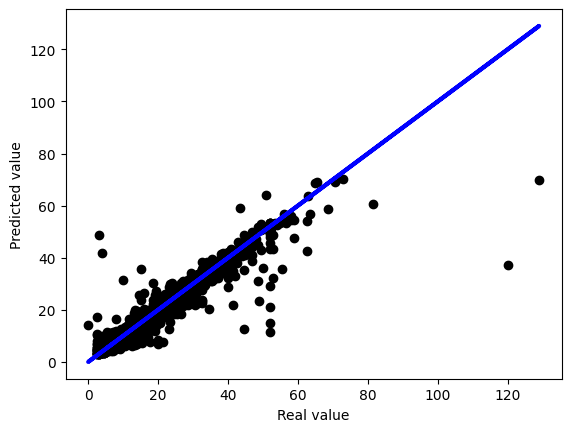

In [12]:
import argparse

from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import mlflow
import mlflow.sklearn

TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance", "dropoff_latitude", "dropoff_longitude", "passengers", "pickup_latitude",
    "pickup_longitude", "pickup_weekday", "pickup_month", "pickup_monthday", "pickup_hour",
    "pickup_minute", "pickup_second", "dropoff_weekday", "dropoff_month", "dropoff_monthday",
    "dropoff_hour", "dropoff_minute", "dropoff_second"
]

CAT_NOM_COLS = [
    "store_forward", "vendor"
]

CAT_ORD_COLS = [
]

train_data = "/tmp/prep/train"
model_output = "/tmp/train"

os.makedirs(model_output, exist_ok = True)

regressor__n_estimators = 500
regressor__bootstrap = 1
regressor__max_depth = 10
regressor__max_features = "auto"
regressor__min_samples_leaf = 4
regressor__min_samples_split = 5

'''Read train dataset, train model, save trained model'''

# Read train data
train_data = pd.read_parquet(Path(train_data) / "train.parquet" )

# Split the data into input(X) and output(y)
y_train = train_data[TARGET_COL]
X_train = train_data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS]

# Train a Random Forest Regression Model with the training set
model = RandomForestRegressor(n_estimators = regressor__n_estimators,
                                bootstrap = regressor__bootstrap,
                                max_depth = regressor__max_depth,
                                max_features = regressor__max_features,
                                min_samples_leaf = regressor__min_samples_leaf,
                                min_samples_split = regressor__min_samples_split,
                                random_state=0)

# log model hyperparameters
mlflow.log_param("model", "RandomForestRegressor")
mlflow.log_param("n_estimators", regressor__n_estimators)
mlflow.log_param("bootstrap", regressor__bootstrap)
mlflow.log_param("max_depth", regressor__max_depth)
mlflow.log_param("max_features", regressor__max_features)
mlflow.log_param("min_samples_leaf", regressor__min_samples_leaf)
mlflow.log_param("min_samples_split", regressor__min_samples_split)

# Train model with the train set
model.fit(X_train, y_train)

# Predict using the Regression Model
yhat_train = model.predict(X_train)

# Evaluate Regression performance with the train set
r2 = r2_score(y_train, yhat_train)
mse = mean_squared_error(y_train, yhat_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, yhat_train)

# log model performance metrics
mlflow.log_metric("train r2", r2)
mlflow.log_metric("train mse", mse)
mlflow.log_metric("train rmse", rmse)
mlflow.log_metric("train mae", mae)

# Visualize results
plt.scatter(y_train, yhat_train,  color='black')
plt.plot(y_train, y_train, color='blue', linewidth=3)
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.savefig("regression_results.png")
mlflow.log_artifact("regression_results.png")

# Save the model
mlflow.sklearn.save_model(sk_model=model, path=model_output)

MLFlow's autolog logs several metadata when <code>model.fit()</code> is executed:
- Hyperparameters used (e.g. n_estimators)
- Metrics calculated on the training set (e.g. MSE, MAE, R2)
- Other metadata, like the class used (e.g. sklearn.ensemble._forest.RandomForestRegressor)

### Evaluate Model <a name="evaluate_model"></a>

2023/04/25 01:11:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.0384b01a-9057-454b-b07e-3d4c6ac85741/metric_info.json already exists.
2023/04/25 01:11:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.0384b01a-9057-454b-b07e-3d4c6ac85741/metric_info.json already exists.
2023/04/25 01:11:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.0384b01a-9057-454b-b07e-3d4c6ac85741/metric_info.json already exists.


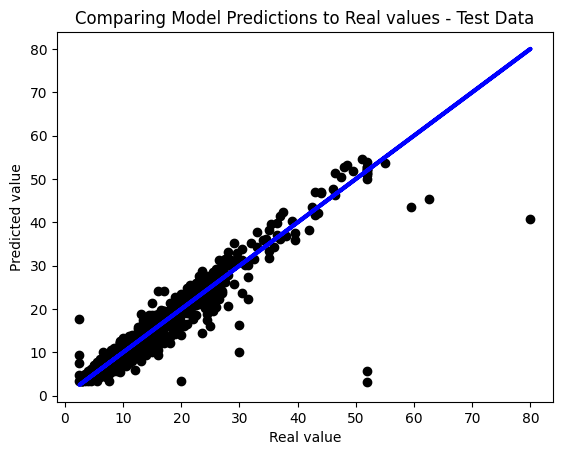

In [13]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

TARGET_COL = "cost"

NUMERIC_COLS = [
    "distance", "dropoff_latitude", "dropoff_longitude", "passengers", "pickup_latitude",
    "pickup_longitude", "pickup_weekday", "pickup_month", "pickup_monthday", "pickup_hour",
    "pickup_minute", "pickup_second", "dropoff_weekday", "dropoff_month", "dropoff_monthday",
    "dropoff_hour", "dropoff_minute", "dropoff_second"
]

CAT_NOM_COLS = [
    "store_forward", "vendor"
]

CAT_ORD_COLS = [
]

model_name = "taxi-model"
model_input = "/tmp/train"
test_data = "/tmp/prep/test"

def model_evaluation(X_test, y_test, model):

    # Get predictions to y_test (y_test)
    yhat_test = model.predict(X_test)

    # Evaluate Model performance with the test set
    r2 = r2_score(y_test, yhat_test)
    mse = mean_squared_error(y_test, yhat_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat_test)

    mlflow.log_metric("test r2", r2)
    mlflow.log_metric("test mse", mse)
    mlflow.log_metric("test rmse", rmse)
    mlflow.log_metric("test mae", mae)

    # Visualize results
    plt.scatter(y_test, yhat_test,  color='black')
    plt.plot(y_test, y_test, color='blue', linewidth=3)
    plt.xlabel("Real value")
    plt.ylabel("Predicted value")
    plt.title("Comparing Model Predictions to Real values - Test Data")
    plt.savefig("predictions.png")
    mlflow.log_artifact("predictions.png")

    return yhat_test, r2


'''Read trained model and test dataset, evaluate model and save result'''

# Load the test data
test_data = pd.read_parquet(Path(test_data)/"test.parquet")

# Split the data into inputs and outputs
y_test = test_data[TARGET_COL]
X_test = test_data[NUMERIC_COLS + CAT_NOM_COLS + CAT_ORD_COLS]

# Load the model from input port
model =  mlflow.sklearn.load_model(model_input) 

# ---------------- Model Evaluation ---------------- #
yhat_test, score = model_evaluation(X_test, y_test, model)

MLFlow's autolog can also log metrics that were calculated after the fit, for example evaluation metrics on the test set.

NB: The metrics should be calculated with supported APIs, like the scikit-learn metric APIs. Otherwise, autolog will have no effect and you will have to manually log your metrics.

## Retrieve Logged Metadata <a name="retrieve_metadata"></a>

As we saw earlier, we can retrieve all logged metadata from the UI. But, it is also possible to retrieve them via code.

In [14]:
# Instanciate MLFlow client
mlflow_client = MlflowClient()

In [15]:
# Retrieve MLFlow run from Azure ML run_id
run_id = run.info.run_id
finished_mlflow_run = mlflow_client.get_run(run_id)

In [16]:
# Get logged tags and print them
tags = finished_mlflow_run.data.tags
print(f"Tags logged for experiment:\n")
pprint.pprint(tags)
print("")

Tags logged for experiment:

{'estimator_class': 'sklearn.ensemble._forest.RandomForestRegressor',
 'estimator_name': 'RandomForestRegressor',
 'input_data_path': 'azureml://subscriptions/d5eebdae-19f7-4198-a12e-04fdec08b615/resourcegroups/amldemos/workspaces/amldemos/datastores/datascience/paths//taxi-data.csv',
 'mlflow.rootRunId': '0384b01a-9057-454b-b07e-3d4c6ac85741',
 'mlflow.runName': 'exploration 2023-04-25 01:11',
 'mlflow.user': 'Maggie Mhanna'}



In [17]:
# Get logged params and print them
params = finished_mlflow_run.data.params
print(f"Params logged for experiment:\n")
pprint.pprint(params)

Params logged for experiment:

{'bootstrap': '1',
 'ccp_alpha': '0.0',
 'criterion': 'squared_error',
 'max_depth': '10',
 'max_features': 'auto',
 'max_leaf_nodes': 'None',
 'max_samples': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '4',
 'min_samples_split': '5',
 'min_weight_fraction_leaf': '0.0',
 'model': 'RandomForestRegressor',
 'n_estimators': '500',
 'n_jobs': 'None',
 'oob_score': 'False',
 'random_state': '0',
 'verbose': '0',
 'warm_start': 'False'}


In [18]:
# Get logged metrics and print them
metrics = finished_mlflow_run.data.metrics
print(f"Metrics logged for experiment:\n")
pprint.pprint(metrics)

Metrics logged for experiment:

{'mean_absolute_error-2_X_test': 1.3765201490789196,
 'mean_absolute_error_X_train': 1.0378760158399218,
 'mean_squared_error-2_X_test': 8.342202856045803,
 'mean_squared_error_X_train': 5.686256083308233,
 'r2_score-2_X_test': 0.890662243933538,
 'r2_score_X_train': 0.9342001027287262,
 'test mae': 1.3765201490789196,
 'test mse': 8.342202856045803,
 'test r2': 0.890662243933538,
 'test rmse': 2.8882871837900406,
 'test size': 1437.0,
 'train mae': 1.0378760158399218,
 'train mse': 5.686256083308233,
 'train r2': 0.9342001027287262,
 'train rmse': 2.3845871934798764,
 'train size': 6854.0,
 'training_mean_absolute_error': 1.0378760158399218,
 'training_mean_squared_error': 5.686256083308233,
 'training_r2_score': 0.9342001027287262,
 'training_root_mean_squared_error': 2.3845871934798764,
 'training_score': 0.9342001027287262,
 'val size': 1482.0}


In [19]:
mlflow.end_run()